<hr style="border:1px solid black">

# Defining number of components using stability measures

In [1]:
import sys,json
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns
import os 
from matplotlib import pyplot as plt

sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')

from compute_similarity import compute_similarity
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load the config files with all informations (i.e., all datasets, methods, etc.)
with open('../../config/config_scbr_icap_stability.json') as config_file:
    config = json.load(config_file)

In [3]:
# Initializing parameters
methods = ['icap']
datasets = ['mtl']
nperm = 33
nsub = '10'
save_df = True
load_from_df = False

if load_from_df==True and os.path.isfile(config['main_dir'] + config['output_dir'] + 'perm_df_' + config['output_tag'] + '_' +  nsub + 'sub.csv'):
    perm_df = pd.read_csv(config['main_dir'] + config['output_dir'] + 'perm_df_' + config['output_tag'] + '_' +  nsub + 'sub.csv',delimiter=" ")
else:
    # Create structure to save results
    all_methods = []
    all_datasets = []
    all_kmax = []
    all_sim = []
    all_n = []
    # For each method & dataset
    for method in methods:
        for dataset in datasets:
            krange = range(7,12) if dataset == 'mtl' else range(3,8)
            print(f'Computing stability for {method} in {dataset}')
            # Looping through K and permutations
            for k_i,kmax in enumerate(krange):
                print(f'K = {kmax}')
                 # Load reference data (entire group)
                data_ref = nib.load(glob.glob(config['main_dir']+config['data'][dataset][method]['spinalcord']['dir'] + '/K_' + str(kmax) + '/comp_zscored/*' + config['data'][dataset][method]['spinalcord']["tag_filename"] + '*')[0]).get_fdata()
                for n in range(0,nperm):
                    all_methods.append(method)
                    all_datasets.append(dataset)
                    all_kmax.append(kmax)
                    all_n.append(n)
                    # Load permutation data
                    data_perm = nib.load(glob.glob(config['main_dir']+config['data'][dataset][method + '_perm']['spinalcord']['dir'][nsub] + str(n+1) + '*/K_' + str(kmax) + '*/' + config['data'][dataset][method + '_perm']['spinalcord']['comp_folder'] + '/*' + config['data'][dataset][method + '_perm']['spinalcord']["tag_filename"] + '*.nii*')[0]).get_fdata()            
                    # Compute similarity matrix between perm data and ref 
                    [tmp_mat,_,_] = compute_similarity(config,data_ref,data_perm,method='Dice',thresh1=1.6,thresh2=1.6,verbose=False)
                    # Take mean of the diagonal as a summary measure of similarity
                    all_sim.append(np.mean(np.diag(tmp_mat)))
    colnames = ["method","dataset","kmax","perm","sim"]
    perm_df = pd.DataFrame(list(zip(all_methods, all_datasets, all_kmax, all_n, all_sim)), columns=colnames)
    if save_df == True:
        perm_df.to_csv(config['main_dir'] + config['output_dir'] + 'perm_df_' + config['output_tag'] + '_' +  nsub + 'sub.csv', sep=' ', index=False)

Computing stability for icap in mtl
K = 7
K = 8
K = 9
K = 10
K = 11


<Figure size 432x288 with 0 Axes>

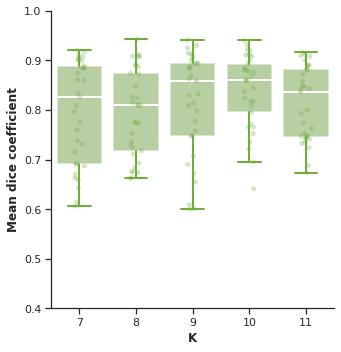

In [6]:
dataset='mtl'
colors=["#72ac3bff","#72ac3bff"]
sns.set(style="ticks",  font='sans-serif')

for method_ind, method in enumerate(methods):
    plt.figure(method_ind)
    g=sns.catplot(y="sim",x="kmax",data=perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method)], kind="box", legend=True, legend_out=True,
                 linewidth=2,medianprops=dict(color="white"),color=colors[method_ind], 
                 boxprops=dict(alpha=.5,edgecolor=None),whiskerprops=dict(color=colors[method_ind]), capprops=dict(color=colors[method_ind]), fliersize=0, aspect=1) #fliersize=0)
    g.set(ylim=(0.4, 1),xlim=(7,11))
    g.fig.set_size_inches(5,5)
    sns.stripplot(y="sim",x="kmax",data=perm_df.loc[(perm_df['dataset']==dataset) & (perm_df['method']==method)],
                 size=5, color=colors[method_ind], alpha=.3, linewidth=0,edgecolor='white',dodge=True)
    
    g.set_axis_labels("K", "Mean dice coefficient",fontsize=12, fontweight='bold')
    g.savefig(config['main_dir'] + config['output_dir'] + config['output_tag'] + '_subsampling_stability_' + dataset + '_' + method+ '_' +  nsub + 'sub.pdf', format='pdf')